# PART 2C

In [1]:
# Import libraries
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the database connection
conn = sqlite3.connect("FlightStats.db")

In [2]:
# SQL queries
query_diverted = """
SELECT 
    f.Year,
    f.DayOfWeek,
    f.Month,
    f.DayofMonth,
    f.CRSDepTime,
    f.CRSArrTime,
    f.UniqueCarrier,
    f.Origin,
    f.Dest,
    f.Distance,
    f.TaxiIn,
    f.TaxiOut,
    f.Diverted
FROM 
    flights f
JOIN (
    SELECT 
        Origin,
        Dest,
        UniqueCarrier
    FROM 
        flights
    WHERE 
        Diverted = 1
        AND Year BETWEEN 1998 AND 2007
    GROUP BY 
        UniqueCarrier, Origin, Dest
    ORDER BY 
        COUNT(*) DESC
    LIMIT 
        25
) t ON f.Origin = t.Origin AND f.Dest = t.Dest AND f.UniqueCarrier = t.UniqueCarrier
WHERE 
    f.Diverted = 1
    AND f.Year BETWEEN 1998 AND 2007
ORDER BY 
    RANDOM()
LIMIT 
    5000;
"""

query_non_diverted = """
SELECT 
    f.Year,
    f.DayOfWeek,
    f.Month,
    f.DayofMonth,
    f.CRSDepTime,
    f.CRSArrTime,
    f.UniqueCarrier,
    f.Origin,
    f.Dest,
    f.Distance,
    f.TaxiIn,
    f.TaxiOut,
    f.Diverted
FROM 
    flights f
JOIN (
    SELECT 
        Origin,
        Dest,
        UniqueCarrier
    FROM 
        flights
    WHERE 
        Diverted = 0
        AND Year BETWEEN 1998 AND 2007
    GROUP BY 
        UniqueCarrier, Origin, Dest
    ORDER BY 
        COUNT(*) DESC
    LIMIT 
        25
) t ON f.Origin = t.Origin AND f.Dest = t.Dest AND f.UniqueCarrier = t.UniqueCarrier
WHERE 
    f.Diverted = 0
    AND f.Year BETWEEN 1998 AND 2007
ORDER BY 
    RANDOM()
LIMIT 
    5000;
"""

# Execute SQL queries and retrieve data
diverted = pd.read_sql_query(query_diverted, conn)
non_diverted = pd.read_sql_query(query_non_diverted, conn)

# Combine diverted and non-diverted data
combined_data = pd.concat([diverted, non_diverted])

# Data cleaning: remove rows with missing values
combined_data.dropna(inplace=True)

In [3]:
# Encode categorical variables
combined_data = pd.get_dummies(combined_data, columns=['UniqueCarrier', 'Origin', 'Dest'])

# Split data into train and test sets
X = combined_data.drop(columns=['Diverted'])
y = combined_data['Diverted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [10]:
# Define function to evaluate logistic regression model
def evaluate_logistic(model, X_test, y_test):
    # Make predictions on test data
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    
    return accuracy, recall, f1, auc

In [21]:
# Initialize lists to store evaluation metrics and coefficients for each year
accuracy_list = []
recall_list = []
f1_list = []
auc_list = []
coefficients_list = []

# Loop through each year
for year in X_train['Year'].unique():
    # Subset the data for the current year
    X_train_year = X_train[X_train['Year'] == year]
    y_train_year = y_train[X_train['Year'] == year]
    X_test_year = X_test[X_test['Year'] == year]
    y_test_year = y_test[X_test['Year'] == year]

    # Fit logistic regression model only if both classes are present
    if len(y_train_year.unique()) > 1:
        model_year = LogisticRegression(max_iter=10000).fit(X_train_year, y_train_year)

        # Store the coefficients
        coefficients_list.append(model_year.coef_[0])

        # Evaluate logistic regression model for the current year
        accuracy_year, recall_year, f1_year, auc_year = evaluate_logistic(model_year, X_test_year, y_test_year)
        
        # Append evaluation metrics to lists
        accuracy_list.append(accuracy_year)
        recall_list.append(recall_year)
        f1_list.append(f1_year)
        auc_list.append(auc_year)
    else:
        # Append NaN values if data contains only one class
        accuracy_list.append(np.nan)
        recall_list.append(np.nan)
        f1_list.append(np.nan)
        auc_list.append(np.nan)
        coefficients_list.append([])  # Append empty list for coefficients

# Create a DataFrame to store evaluation metrics for each year
evaluation_metrics = pd.DataFrame({
    'Year': X_train['Year'].unique(),
    'Accuracy': accuracy_list,
    'Recall': recall_list,
    'F1 Score': f1_list,
    'AUC': auc_list,
    'Coefficients': coefficients_list
})

print(evaluation_metrics)

   Year  Accuracy    Recall  F1 Score       AUC  \
0  2000  0.992032  1.000000  0.993007  0.990826   
1  2006  0.983146  1.000000  0.984456  0.981928   
2  2003  0.932515  0.951613  0.914729  0.936202   
3  2004  0.931250  0.881356  0.904348  0.920876   
4  2002  0.926136  0.927711  0.922156  0.926221   
5  1999  0.982609  1.000000  0.983051  0.982456   
6  2001  0.977169  1.000000  0.976077  0.978632   
7  1998  0.982063  1.000000  0.982759  0.981651   
8  2007  0.985849  1.000000  0.987552  0.983871   
9  2005  0.989362  1.000000  0.990291  0.988372   

                                        Coefficients  
0  [-0.0007628644096786652, 0.00793201090276719, ...  
1  [0.0005157207602047535, -0.14074882334669886, ...  
2  [-0.0014597583130081272, -0.02293555066398277,...  
3  [-0.0019732982252364645, -0.07938825960601953,...  
4  [-0.002133825336209988, -0.07227663011390847, ...  
5  [-0.0003265623125557038, 0.1403694501078266, 0...  
6  [-0.0008402532659588393, 0.10339052914531605, ... 

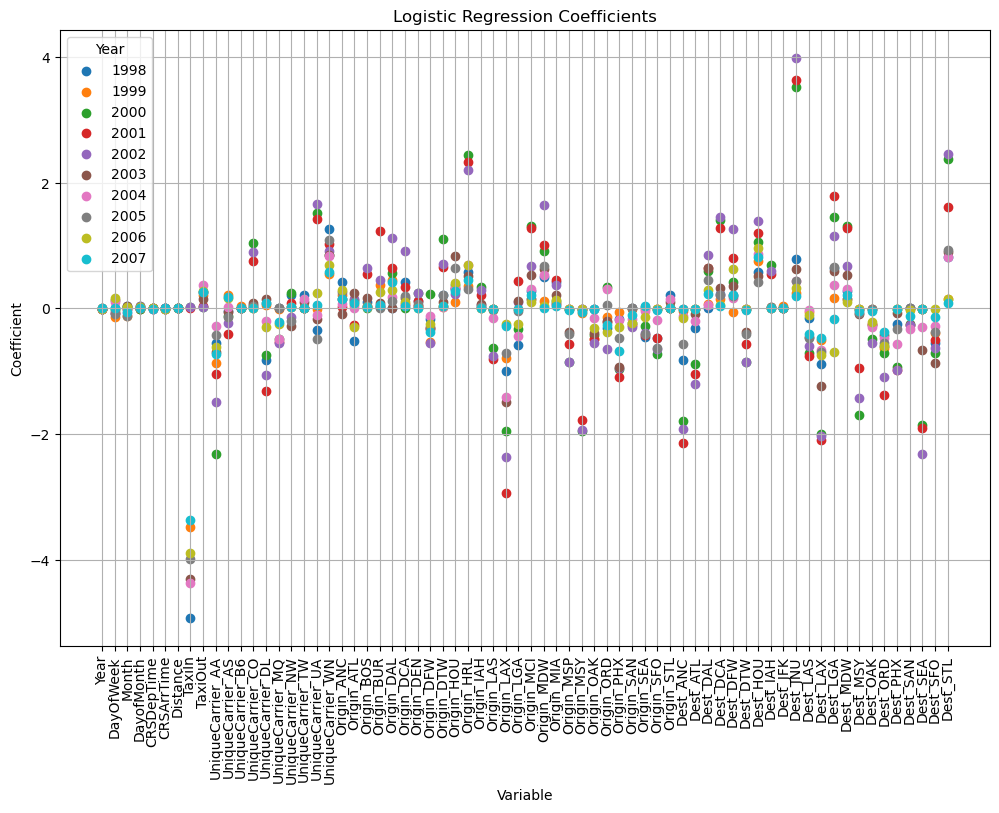

In [23]:
# Get unique years and sort them
unique_years = sorted(X_train['Year'].unique())

# Plot the coefficients as dot diagram with different colors for each year
plt.figure(figsize=(12, 8))
for i, year in enumerate(unique_years):
    coefficients_year = coefficients_list[i]
    variables_year = variable_names
    plt.scatter(variables_year, coefficients_year, color=color_map(i), label=year)

plt.title('Logistic Regression Coefficients')
plt.xlabel('Variable')
plt.ylabel('Coefficient')
plt.xticks(rotation=90)
plt.legend(title='Year', loc='upper left')
plt.grid(True)
plt.show()